In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split

import os
import sys
import pickle
import logging
from pathlib import Path
from math import log, ceil
from typing import List, Tuple, Set, Dict

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
from src.data import prepare_data, SOURCE_ASSIST0910_SELF, SOURCE_ASSIST0910_ORIG

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

PyTorch: 1.0.1.post2
GPU: True
2
0


INFO:dkt log:TRAIN Epoch: 10 Loss: 0.6577666211128235
INFO:dkt log:TRAIN Epoch: 10 AUC: 0.6139588543037642
INFO:dkt log:EVAL  Epoch: 10 Loss: 0.6573888262112936
INFO:dkt log:EVAL  Epoch: 10 AUC: 0.6096100983796297
INFO:dkt log:TRAIN Epoch: 20 Loss: 0.6409571576118469
INFO:dkt log:TRAIN Epoch: 20 AUC: 0.6420357330876547
INFO:dkt log:EVAL  Epoch: 20 Loss: 0.6415350834528605
INFO:dkt log:EVAL  Epoch: 20 AUC: 0.6348319347993827
INFO:dkt log:TRAIN Epoch: 30 Loss: 0.6254487490653992
INFO:dkt log:TRAIN Epoch: 30 AUC: 0.6639459671404756
INFO:dkt log:EVAL  Epoch: 30 Loss: 0.6268081565697988
INFO:dkt log:EVAL  Epoch: 30 AUC: 0.6524884259259259
INFO:dkt log:TRAIN Epoch: 40 Loss: 0.6184302425384521
INFO:dkt log:TRAIN Epoch: 40 AUC: 0.6705180776739492
INFO:dkt log:EVAL  Epoch: 40 Loss: 0.6173391342163086
INFO:dkt log:EVAL  Epoch: 40 AUC: 0.6583779417438271
INFO:dkt log:TRAIN Epoch: 50 Loss: 0.6119679832458496
INFO:dkt log:TRAIN Epoch: 50 AUC: 0.6808528285952444
INFO:dkt log:EVAL  Epoch: 50 Loss: 0.

100 100 100


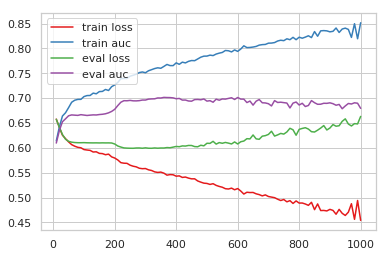

In [3]:
# =========================
# PyTorch version & GPU setup
# =========================
print('PyTorch:', torch.__version__)
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)
if use_gpu:
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
dev = torch.device('cuda' if use_gpu else 'cpu')


# =========================
# Parameters
# =========================
lr = 0.01
batch_size, n_hidden, n_skills, n_layers = 100, 200, 124, 2
n_output = n_skills
onehot_size = n_skills * 2 + 1
n_input = ceil(log(2 * n_skills))
# n_input = onehot_size  #
sequence_size = 30

# =========================
# Data
# =========================
x_onehot, y_onehot, y_onehot_q, y_onehot_a = prepare_data(SOURCE_ASSIST0910_ORIG, n_skills, 3, sequence_size)


x_tensor, y_tensor = torch.Tensor(x_onehot).to(dev), torch.Tensor(y_onehot).to(dev)
y_tensor_q, y_tensor_a = torch.Tensor(y_onehot_q).to(dev), torch.Tensor(y_onehot_a).to(dev)
all_ds = TensorDataset(x_tensor, y_tensor_q, y_tensor_a)
train_num = int(len(all_ds) * .8)
train_ds, eval_ds = random_split(all_ds, [train_num, len(all_ds) - train_num])

all_dl = DataLoader(all_ds, batch_size=batch_size, drop_last=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, drop_last=True)


# =========================
# Model
# =========================
class DKT(nn.Module):
    ''' オリジナルのDKT
    200 epochくらいでeval lossの減少とaucの増加が止まった'''
    def __init__(self, dev, n_input, n_hidden, n_output, n_layers, batch_size, dropout=0.6, bidirectional=False):
        super(DKT, self).__init__()
        self.dev = dev
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.bidirectional = bidirectional
        self.directions = 2 if self.bidirectional else 1
        
        nonlinearity = 'tanh'
        # https://pytorch.org/docs/stable/nn.html#rnn
        self.rnn = nn.RNN(n_input, n_hidden, n_layers,
                          nonlinearity=nonlinearity, dropout=dropout, bidirectional=self.bidirectional)
        self.decoder = nn.Linear(n_hidden * self.directions, n_output)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        h0 = self.initHidden0()
        out, _hn = self.rnn(input, h0)
        # top_n, top_i = out.topk(1)
        # decoded = self.decoder(out.contiguous().view(out.size(0) * out.size(1), out.size(2)))
        out = self.decoder(out)
        # decoded = self.sigmoid(decoded)

        return out
    
    def initHidden0(self):
        return torch.zeros(self.n_layers * self.directions, self.batch_size, self.n_hidden).to(self.dev)

    
class _DKT(nn.Module):
    ''' オリジナルのDKTをさらに忠実に
    '''
    def __init__(self, dev, n_input, n_hidden, n_output, n_layers, batch_size, dropout=0.6):
        super(DKT, self).__init__()
        nonlinearity = 'tanh'
        # https://pytorch.org/docs/stable/nn.html#rnn
        self.rnn = nn.RNN(n_input, n_hidden, n_layers + 1,
                          nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(n_hidden, n_output)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input, h0):
        out, hn = self.rnn(input, h0)
        # top_n, top_i = out.topk(1)
        # decoded = self.decoder(out.contiguous().view(out.size(0) * out.size(1), out.size(2)))
        out = self.decoder(out)
        # decoded = self.sigmoid(decoded)

        return out, hn
    

# =========================
# Prepare and Train
# =========================
loss_func = nn.BCELoss()
model = DKT(dev, n_input, n_hidden, n_output, n_layers, batch_size)
model.to(dev)
criterion = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=lr)

    
def main():
    debug = False
    logging.basicConfig()
    logger = logging.getLogger('dkt log')
    logger.setLevel(logging.INFO)
    train_loss_list = []
    train_auc_list = []
    eval_loss_list = []
    eval_auc_list = []
    eval_recall_list = []
    eval_f1_list = []
    x = []
    for epoch in range(1, 1001):
        print_train = epoch % 10 == 0
        print_eval = epoch % 10 == 0
        print_auc = epoch % 10 == 0

        
        # TRAIN
        model.train()

        val_prob = []
        val_targ = []
        current_epoch_train_loss = []
        for xs, yq, ya in train_dl:
            input = xs
            compressed_sensing = True
            if compressed_sensing and onehot_size != n_input:
                torch.manual_seed(0)
                cs_basis = torch.randn(onehot_size, n_input).to(dev)
                input = torch.mm(
                    input.contiguous().view(-1, onehot_size), cs_basis)
                # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
                # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
                input = input.view(batch_size, sequence_size, n_input)
            input = input.permute(1, 0, 2)

            target = ya

            out = model(input)
            
            pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
            prob = torch.max(pred * yq, 1)[0]
            loss = criterion(prob, target)  # TODO: 最後の1個だけじゃなくて、その他も損失関数に利用したら？
            
            current_epoch_train_loss.append(loss.item())
            
            # 指標評価用データ
            val_prob.append(prob)
            val_targ.append(target)

            # バックプロバゲーション
            opt.zero_grad()
            loss.backward()
            opt.step()

            # stop at first batch if debug
            if debug:
                break
                
        if print_train:
            loss = np.array(current_epoch_train_loss)
            logger.info('TRAIN Epoch: {} Loss: {}'.format(epoch, loss.mean()))
            train_loss_list.append(loss.mean())
            
            # AUC, Recall, F1
            # TRAINの場合、勾配があるから処理が必要
            y = torch.cat(val_targ).cpu().detach().numpy()
            pred = torch.cat(val_prob).cpu().detach().numpy()
            # AUC
            fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
            logger.info('TRAIN Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
            train_auc_list.append(metrics.auc(fpr, tpr))


        # EVAL
        if print_eval:
            with torch.no_grad():
                model.eval()

                val_prob = []
                val_targ = []
                current_eval_loss = []
                for xs, yq, ya in eval_dl:
                    input = xs
                    if compressed_sensing:
                        torch.manual_seed(0)
                        cs_basis = torch.randn(onehot_size, n_input).to(dev)
                        # 行列の内積
                        input = torch.mm(
                            input.contiguous().view(-1, onehot_size), cs_basis)
                        # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
                        # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
                        input = input.view(batch_size, sequence_size, n_input)
                    input = input.permute(1, 0, 2)
                    target = ya
                    
                    out = model(input)
                    
                    pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
                    prob = torch.max(pred * yq, 1)[0]
                    loss = criterion(prob, target)

                    current_eval_loss.append(loss.item())

                    # 指標評価用データ
                    val_prob.append(prob)
                    val_targ.append(target)

                    # stop at first batch if debug
                    if debug:
                        break
                        
                loss = np.array(current_eval_loss)
                logger.info('EVAL  Epoch: {} Loss: {}'.format(epoch,  loss.mean()))
                eval_loss_list.append(loss.mean())

                # AUC, Recall, F1
                if print_auc:
                    y = torch.cat(val_targ).cpu()
                    pred = torch.cat(val_prob).cpu()
                    # AUC
                    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
                    logger.info('EVAL  Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
                    eval_auc_list.append(metrics.auc(fpr, tpr))
                    # Recall
                    logger.debug('EVAL  Epoch: {} Recall: {}'.format(epoch, metrics.recall_score(y, pred.round())))
                    # F1 score
                    logger.debug('EVAL  Epoch: {} F1 score: {}'.format(epoch, metrics.f1_score(y, pred.round())))
        
        if epoch % 10 == 0:
            x.append(epoch)

        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, train_loss_list, label='train loss')
    ax.plot(x, train_auc_list, label='train auc')
    ax.plot(x, eval_loss_list, label='eval loss')
    ax.plot(x, eval_auc_list, label='eval auc')
    ax.legend()
    print(len(train_loss_list), len(eval_loss_list), len(eval_auc_list))
    plt.show()


if __name__ == '__main__':
    main()